# Import the necessary packages and set directory to sourcecode folder

In [2]:
import sys
from pathlib import Path
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandapower as pp, pandapower.networks as pn

# Notebook cwd is ".../LV network/Codes"
cwd = Path.cwd()

# Helpers live in the sibling "sourcecode" folder under Codes:
helpers_dir = (cwd / "sourcecode").resolve()
print("Adding to sys.path:", helpers_dir)
sys.path.insert(0, str(helpers_dir))

Adding to sys.path: E:\GitHubProjects\LV network\Codes\sourcecode


Now import the capsuled modules by name (filename without .py)


In [3]:
# This is for plotting the network results
from Network_Plotting import plot_pf_with_transformer_capacity

# This is for the RC optimization model
import RC_Optimization as rc

from Residential_CIGRE_LV_network import R_LV_CIGRE

from Load_aggregation import mc_assign_households, load_aggregation_by_nodes
# Here is a residential pandapower network extracted from the CIGRE LV network.

from MC_simulation import run_and_save_monte_carlo_simulation

First Generate the demand profile by individual household models, then save them to CSV files.

                       Q_hp  Q_bo        Tin  T_set  T_low  T_high
2022-01-03 00:00:00     0.0   0.0  21.000000   15.0   15.0     NaN
2022-01-03 00:30:00     0.0   0.0  20.855613   15.0   15.0     NaN
2022-01-03 01:00:00     0.0   0.0  20.713530   15.0   15.0     NaN
2022-01-03 01:30:00     0.0   0.0  20.569575   15.0   15.0     NaN
2022-01-03 02:00:00  4000.0   0.0  20.419027   15.0   15.0     NaN
Figure saved to figures\Daily_Tol0.5_2022-01-03_to_2022-01-04_4kW_HHP_results.png
Results saved to: E:\GitHubProjects\LV network\Data_for_CIGRE_Network\Daily_Tol0.5_2022-01-03_to_2022-01-04_4kW_HHP_results.csv


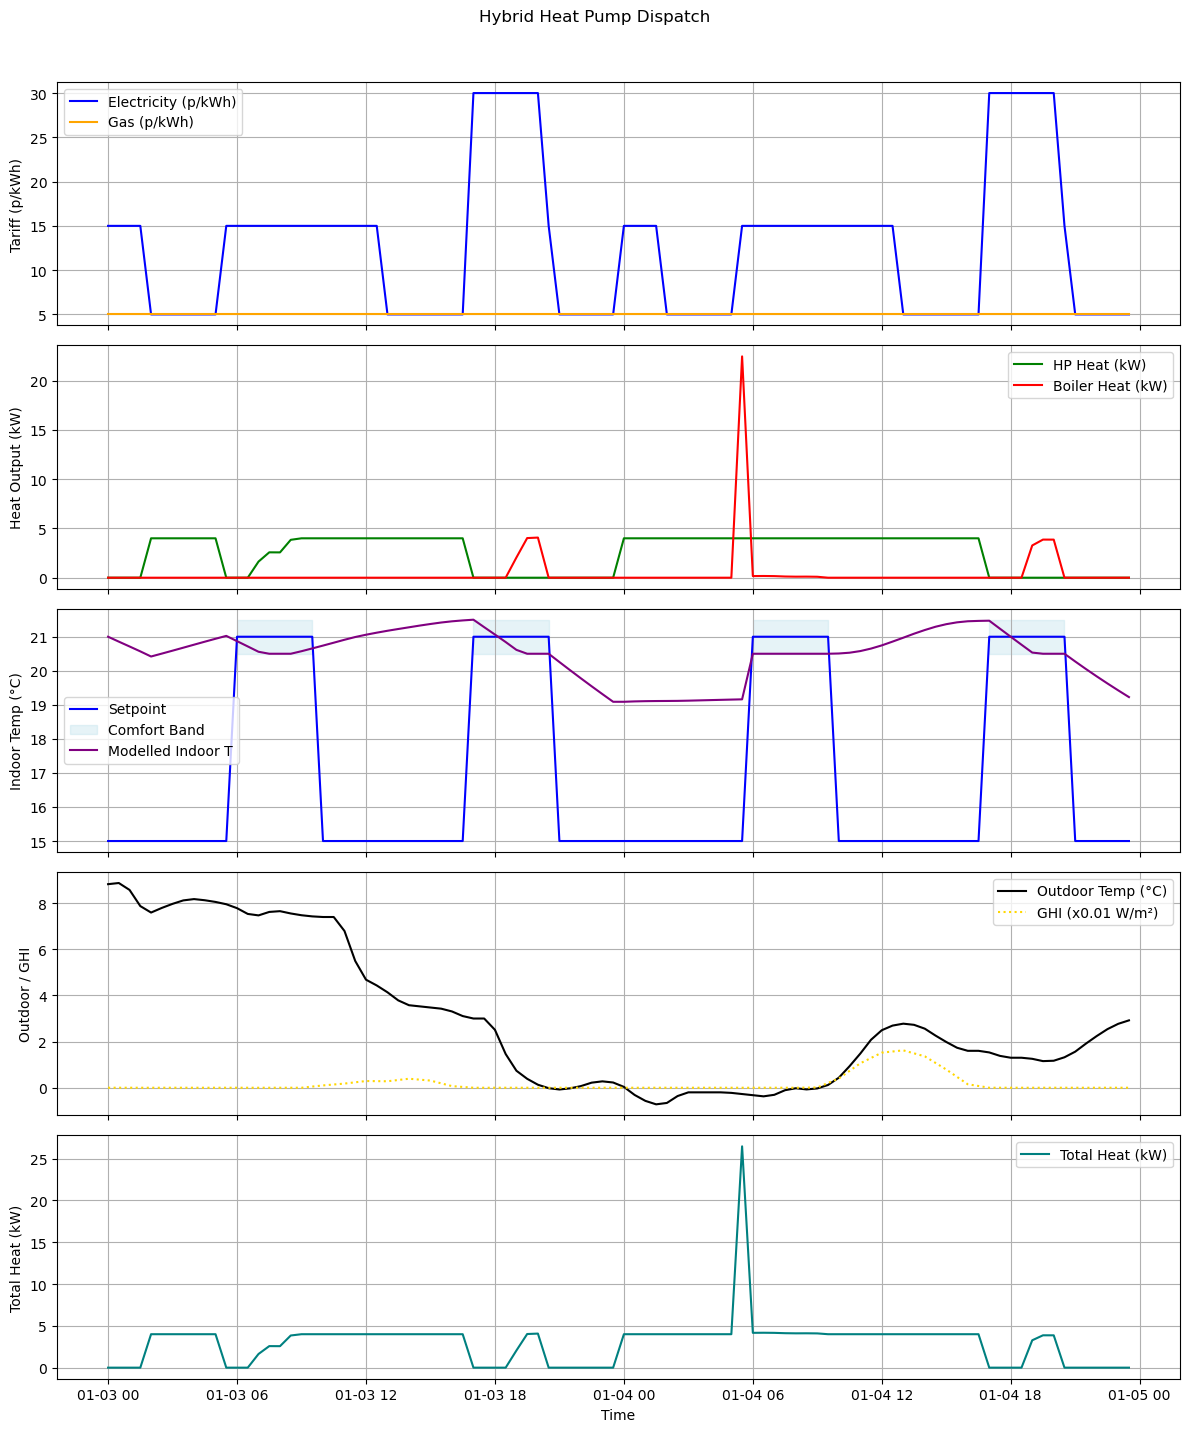

In [7]:
start_date = pd.to_datetime("2022-01-03")
n_days = 2                 # simulation horizon (days)
step = "30min"              # time resolution
tariff_type = "cozy"        # "standard", "eco", "comfort", ...
data_path = Path(r"E:\Python projects\RC model\Test data\Property_ID=EOH0031_2022_01.csv")
out_dir = Path(r"E:\GitHubProjects\LV network\Data_for_CIGRE_Network")

# HVAC / building parameters
R1, C1, g = 1 / 200, 3e7, 10.0
T0        = 21              # initial indoor temperature, °C
COP       = 3.5             # heat‑pump COP
etaB      = 0.9             # boiler efficiency
Qhp_max   = 4e3             # heat‑pump capacity, W
Qbo_max   = 24e3               # 0 ⇒ pure HP ; >0 ⇒ hybrid HP/boiler
day_ahead = True           # use day‑ahead optimization
# --- Build multi‑day tariff --------------------------------------------------

tariff = rc.build_tariff(
    start_date=start_date,
    n_days=n_days,
    step=step,
    type=tariff_type,
)

# --- Load & align input data -------------------------------------------------

df = pd.read_csv(
    data_path,
    parse_dates=["Timestamp"],
    index_col="Timestamp",
)
df = df.loc[tariff.index[0] : tariff.index[-1]]   # clip to optimisation window

dt   = df.index.to_series().diff().median().total_seconds()
Tout = df["External_Air_Temperature"].values
S    = df["GHI"].values

# --- Build thermostat schedule ----------------------------------------------

hours  = tariff.index.hour
T_set  = np.where(
    ((hours >= 6) & (hours < 10)) | ((hours >= 17) & (hours < 21)),
    21.0,
    15.0,
)
tol = 0.5                                        # ± °C comfort band

# --- Optimise operation ------------------------------------------------------

results = rc.optimize_hhp_operation(
    R1,
    C1,
    g,
    tariff,
    Tout,
    S,
    dt,
    T0,
    T_setpoint=T_set,
    tol=tol,
    COP=COP,
    etaB=etaB,
    Qhp_max=Qhp_max,
    Qbo_max=Qbo_max,
    day_ahead=day_ahead,
)

print(results.head())

# --- Plot results ------------------------------------------------------------
# --- Post‑process & export ---------------------------------------------------

results["Pe_hp"] = results["Q_hp"] / COP   # electrical power (W)
results["Pg_bo"] = results["Q_bo"] / etaB  # boiler gas power (W)

# Build dynamic, descriptive file name
date_fmt  = "%Y-%m-%d"
start_str = tariff.index[0].strftime(date_fmt)
end_str   = tariff.index[-1].strftime(date_fmt)
hp_tag    = "HP" if Qbo_max == 0 else "HHP"

if day_ahead:
    file_name = (
        f"Daily_Tol{tol}_{start_str}_to_{end_str}_{int(Qhp_max/1000)}kW_{hp_tag}_results.csv"
    )
else:
    file_name = (
        f"Global_Tol{tol}_{start_str}_to_{end_str}_{int(Qhp_max/1000)}kW_{hp_tag}_results.csv"
    )


rc.plot_hhp_results_components(
    Tin=results["Tin"].values,
    Q_hp=results["Q_hp"].values,
    Q_bo=results["Q_bo"].values,
    T_set=results["T_set"].values,
    T_low=results["T_low"].values,
    T_high=results["T_high"].values,
    index=results.index,
    tariff=tariff,
    df=df,
    filename=file_name[:-4] + ".png",
)

# Save results to CSV
results.to_csv(out_dir / file_name)
print(f"Results saved to: {out_dir / file_name}")

Initialize the pandapower network, and plot the network

In [6]:
net = R_LV_CIGRE()
pp.runpp(net, numba=False)
plot_pf_with_transformer_capacity(net, filename="test11.png")

Plot saved to figures\test11.png


This block below is used for 
1. assigning households to each node in the pandapower network
2. randomly assigning HHPs and HPs to the households based on the given percentage
3. aggregating the load by nodes based on the household assignment and the HHP/HP results

In [7]:
df_HHP_dir= r"E:\GitHubProjects\LV network\Data_for_CIGRE_Network\Daily_Jan_2022_4.0kW_HHP_results.csv"
df_HP_dir = r"E:\GitHubProjects\LV network\Data_for_CIGRE_Network\Daily_Jan_2022_7.0kW_HP_results.csv"

df_load_info = mc_assign_households(net, hhp_percentage=1, seed=42)
# This function assigns households to each node in the pandapower network, and randomly assigns HHPs and HPs to the households based on the given percentage.

df_load_by_nodes = load_aggregation_by_nodes(df_load_info, df_HHP_dir, df_HP_dir)
# This function aggregates the load by nodes based on the household assignment and the HHP/HP results.

       name  n_HHP
0   Load R1     58
1  Load R11      4
2  Load R15     15
3  Load R16     16
4  Load R17     10
5  Load R18     14


In [9]:
#checking results
display(df_load_info)
display(df_load_by_nodes.head(24))

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,n_household,n_HHP
0,Load R1,2,0.19000,0.062450,0.0,0.0,NaN,1.0,True,wye,58.0,11
1,Load R11,12,0.01425,0.004684,0.0,0.0,NaN,1.0,True,wye,4.0,0
2,Load R15,16,0.04940,0.016237,0.0,0.0,NaN,1.0,True,wye,15.0,4
3,Load R16,17,0.05225,0.017174,0.0,0.0,NaN,1.0,True,wye,16.0,2
4,Load R17,18,0.03325,0.010929,0.0,0.0,NaN,1.0,True,wye,10.0,3
5,Load R18,19,0.04465,0.014676,0.0,0.0,NaN,1.0,True,wye,14.0,3


,Baseload(W),HHP(W),HP(W),Load R1,Load R11,Load R15,Load R16,Load R17,Load R18
td,,,,,,,,,
2022-01-01 00:00:00,276.000000,0.000000,0.000000,16008.000000,1104.000000,4140.000000,4416.000000,2760.000000,3864.000000
2022-01-01 00:30:00,293.416043,0.000000,0.000000,17018.130481,1173.664171,4401.240642,4694.656684,2934.160428,4107.824599
2022-01-01 01:00:00,287.023396,0.000000,0.000000,16647.356952,1148.093583,4305.350936,4592.374332,2870.233957,4018.327540
2022-01-01 01:30:00,283.236847,0.000000,0.000000,16427.737105,1132.947387,4248.552700,4531.789546,2832.368466,3965.315853
2022-01-01 02:00:00,274.809729,1142.857143,0.000000,28510.392863,1099.238917,8693.574509,6682.669952,6176.668720,7275.907637
2022-01-01 02:30:00,266.382612,1142.857143,0.000000,28021.620050,1065.530447,8567.167747,6547.836073,6092.397546,7157.927992
2022-01-01 03:00:00,257.955494,1142.857143,0.000000,27532.847236,1031.821977,8440.760985,6413.002193,6008.126371,7039.948348
2022-01-01 03:30:00,249.528377,1142.857143,0.000000,27044.074423,998.113507,8314.354223,6278.168314,5923.855196,6921.968703
2022-01-01 04:00:00,241.849899,1142.857143,0.000000,26598.722689,967.399594,8199.177050,6155.312663,5847.070414,6814.470009


# Now it's time to aggregate the RC model results to the baseload and update the pandapower network


Here the time series of demand by load is aggregated


Now Feed it into the network, across the timeframe, run power flow at each timestep and look at the maximum metrics over time

In [10]:
assert isinstance(df_load_by_nodes.index, pd.DatetimeIndex)
# Make sure the index is in the same format as the pandapower network

timestamps = df_load_by_nodes.index
n_steps = len(timestamps)

n_lines = len(net.line)
n_trafos = len(net.trafo)
n_buses = len(net.bus)

line_power = np.zeros((n_steps, n_lines))  # actual real power in MW
line_loading = np.zeros((n_steps, n_lines))
trafo_loading = np.zeros((n_steps, n_trafos))
bus_voltage = np.zeros((n_steps, n_buses))

for i, t in enumerate(timestamps):
    # 1) Update each load in the network
    for name in df_load_by_nodes.columns:
        if name in net.load.name.values:
            load_idx = net.load.index[net.load["name"] == name][0]
            p_kw = df_load_by_nodes.loc[t, name] / 1000  # convert W → kW
            net.load.at[load_idx, "p_mw"] = p_kw / 1000  # kW → MW

    # 2) Run power flow
    try:
        pp.runpp(net, numba=False)
    except:
        print(f"Power flow failed at {t}")
        continue

    # 3) Store results
    line_loading[i, :] = net.res_line.loading_percent.values
    trafo_loading[i, :] = net.res_trafo.loading_percent.values
    bus_voltage[i, :] = net.res_bus.vm_pu.values
    line_power[i, :] = net.res_line.p_from_mw.values

max_line_loading = line_loading.max(axis=0)
max_line_power   = np.abs(line_power).max(axis=0)  # max absolute P per line
max_trafo_loading = trafo_loading.max(axis=0)
min_bus_voltage = bus_voltage.min(axis=0)
max_bus_voltage = bus_voltage.max(axis=0)

# Overwrite net.res_* with worst-case values
net.res_line["loading_percent"] = max_line_loading
net.res_line["p_from_mw"] = max_line_power  # overwrite with max |P|
net.res_trafo["loading_percent"] = max_trafo_loading
net.res_bus["vm_pu"] = min_bus_voltage  # or use max for overvoltage

plot_pf_with_transformer_capacity(
    net,
    bus_cmap="plasma",
    power_cmap="coolwarm",
    filename="max_stress_pf.png"
)

Plot saved to figures\max_stress_pf.png


# Next, we try to compile the Monte Carlo for each penetration of HHPs and HPs.
Start with the Monte Carlo for single penetration of HHP

In [5]:
line_perc, line_p_perc, trafo_perc, bus_vmin_perc = run_and_save_monte_carlo_simulation(n_samples=10, hhp_percentage=0,df_HP_dir=df_HP_dir, df_HHP_dir=df_HHP_dir)


--- MC Sample 1/10 ---
       name  n_HHP
0   Load R1      0
1  Load R11      0
2  Load R15      0
3  Load R16      0
4  Load R17      0
5  Load R18      0

--- MC Sample 2/10 ---
       name  n_HHP
0   Load R1      0
1  Load R11      0
2  Load R15      0
3  Load R16      0
4  Load R17      0
5  Load R18      0

--- MC Sample 3/10 ---
       name  n_HHP
0   Load R1      0
1  Load R11      0
2  Load R15      0
3  Load R16      0
4  Load R17      0
5  Load R18      0

--- MC Sample 4/10 ---
       name  n_HHP
0   Load R1      0
1  Load R11      0
2  Load R15      0
3  Load R16      0
4  Load R17      0
5  Load R18      0

--- MC Sample 5/10 ---
       name  n_HHP
0   Load R1      0
1  Load R11      0
2  Load R15      0
3  Load R16      0
4  Load R17      0
5  Load R18      0

--- MC Sample 6/10 ---
       name  n_HHP
0   Load R1      0
1  Load R11      0
2  Load R15      0
3  Load R16      0
4  Load R17      0
5  Load R18      0

--- MC Sample 7/10 ---
       name  n_HHP
0   Load R1    

Then Monte Carlo for multiple penetration of HHPs and HPs

In [10]:
for hhp_percentage in np.round(np.linspace(0,1,11),2):
    run_and_save_monte_carlo_simulation(n_samples=10, hhp_percentage=hhp_percentage,df_HP_dir=df_HP_dir, df_HHP_dir=df_HHP_dir,out_dir= r"E:\GitHubProjects\LV network\Codes\Output\TestDaily")


--- MC Sample 1/1 ---
       name  n_HHP
0   Load R1      0
1  Load R11      0
2  Load R15      0
3  Load R16      0
4  Load R17      0
5  Load R18      0
Saved Monte Carlo results to: E:\GitHubProjects\LV network\Codes\Output\TestDaily/montecarlo_results_HHP_00p_1samples.csv

--- MC Sample 1/10 ---
       name  n_HHP
0   Load R1      8
1  Load R15      1
2  Load R16      1
3  Load R17      1

--- MC Sample 2/10 ---
       name  n_HHP
0   Load R1      4
1  Load R15      2
2  Load R16      2
3  Load R17      2
4  Load R18      1

--- MC Sample 3/10 ---
       name  n_HHP
0   Load R1      5
1  Load R15      3
2  Load R16      1
3  Load R17      1
4  Load R18      1

--- MC Sample 4/10 ---
       name  n_HHP
0   Load R1      5
1  Load R15      3
2  Load R16      1
3  Load R18      2

--- MC Sample 5/10 ---
       name  n_HHP
0   Load R1      5
1  Load R11      1
2  Load R15      3
3  Load R16      2

--- MC Sample 6/10 ---
       name  n_HHP
0   Load R1      3
1  Load R11      1
2  Load 

Here are some codes for plotting the aggregated results of the HHP and HP operation (RC model)

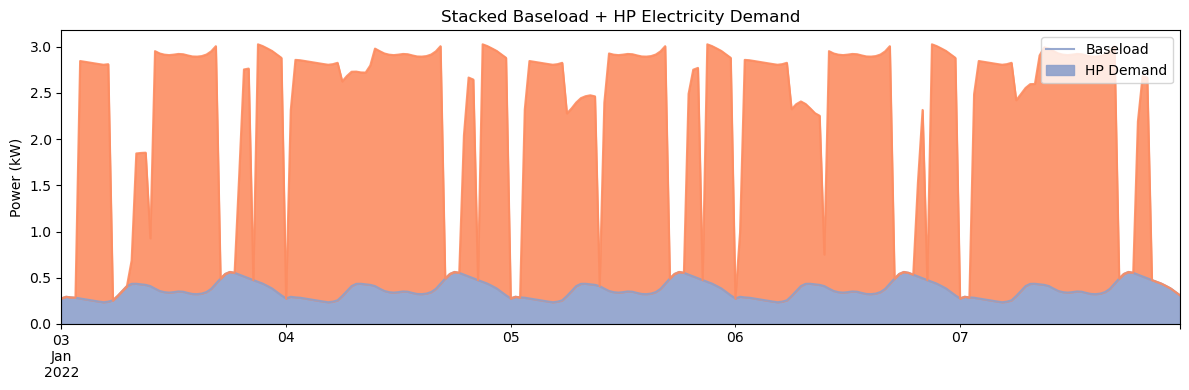

In [44]:
# Load the baseload and aggregate

# --- PARAMETERS ---
# path to your baseload CSV
# (first column: x in hours [0,0.5,...,23.5]; second column: y in kW)
basename = "E:\GitHubProjects\LV network\Data_for_CIGRE_Network\Baseload_from_SERL.csv"

# the date(s) of your simulation run
# e.g. your results.index runs from 2022-01-10 00:00 to 2022-01-15 23:30
sim_start = results.index[0].normalize()
sim_end   = results.index[-1].normalize()

# -------------------------------------------------------------------------
# 1) Load and prepare the baseload profile
# -------------------------------------------------------------------------
df_base = pd.read_csv(
    basename,
    names=["x","Pe_W"],       # since your file has no header
    header=0,           
)

# convert 'x' → a Timedelta (hours)
df_base["td"] = pd.to_timedelta(df_base["x"], unit="h")

# set that as index and keep only the load column
df_base = df_base.set_index("td")

# replicate for each simulation day (if multi‐day)
# here we assume you want the same pattern each day
all_days = pd.date_range(sim_start, sim_end, freq="D")
profiles = []
for day in all_days:
    # shift the half‐hourly pattern onto this calendar day
    prof = df_base.copy()
    prof.index = day + prof.index
    profiles.append(prof)

baseload = pd.concat(profiles)
baseload["Baseload_kW"] = baseload["Pe_W"] / 1000.0  # convert to kW
# Now baseload.index runs from sim_start+0h to sim_end+23.5h

# -------------------------------------------------------------------------
# 2) Turn your HP output into kW and align with baseload
# -------------------------------------------------------------------------
# results["Q_hp"] is in W → convert to kW
results["Elec_hp_kW"] = results["Q_hp"] / 1000.0 / COP

# join the two series onto a single DataFrame
df = pd.concat(
    [results["Elec_hp_kW"], baseload["Baseload_kW"]],
    axis=1
).fillna(0.0)   # any missing timestamps get zero load

# -------------------------------------------------------------------------
# 3) Compute total demand and inspect
# -------------------------------------------------------------------------
df["Total_Elec_kW"] = df["Elec_hp_kW"] + df["Baseload_kW"]

colors = ["#8DA0CB",  # pastel blue
          "#FC8D62"]  # pastel orange

ax = df[["Baseload_kW","Elec_hp_kW"]].plot.area(
    figsize=(12,4),
    stacked=True,
    alpha=0.9,
    color=colors
)
ax.set_ylabel("Power (kW)")
ax.set_title("Stacked Baseload + HP Electricity Demand")
ax.legend(["Baseload","HP Demand"], loc="upper right")
plt.tight_layout()
plt.show()